In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3c
commitnumber = f17e0b2
conc = 0.0008
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
w_diffuse = [(1.7, 1.6, 1.8), (1.8, 1.7), (1.5, 1.6, 1.7, 1.8)]
wgt = [(0.6, 0.4, 0.7), (0.7, 0.5), (0.3, 0.4, 0.85, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

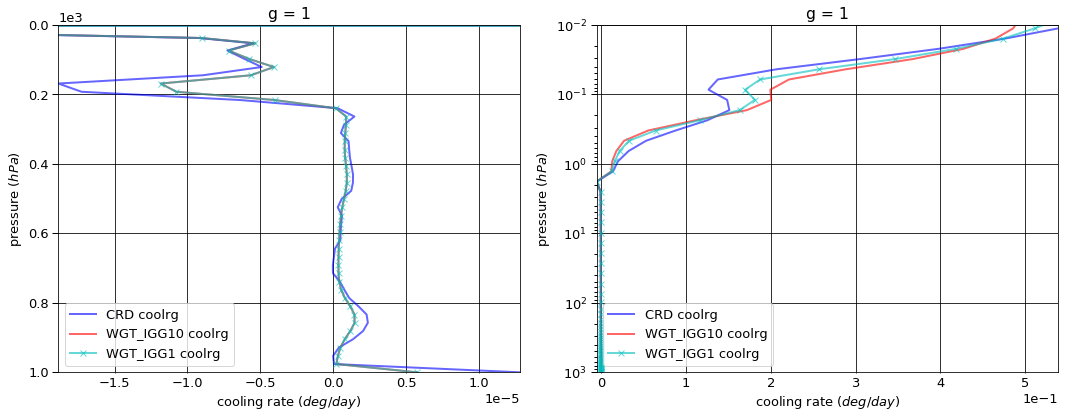

# Figure: cooling rate g-group 2

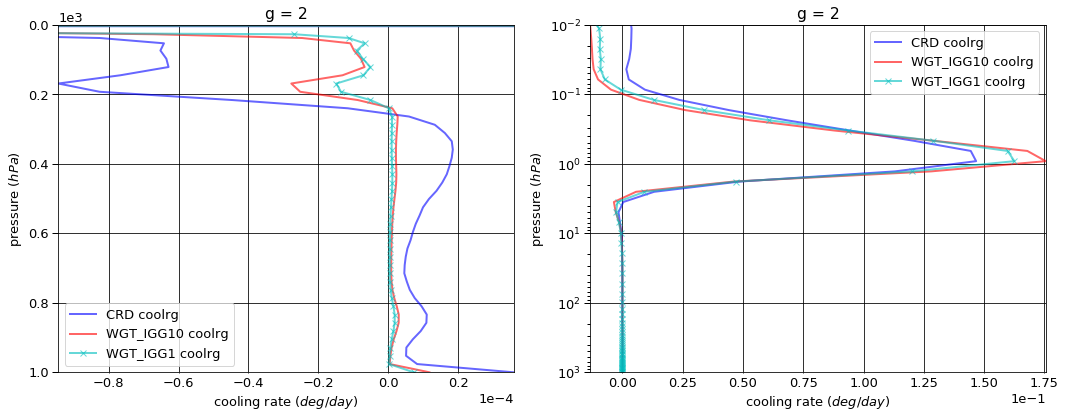

# Figure: cooling rate g-group 3

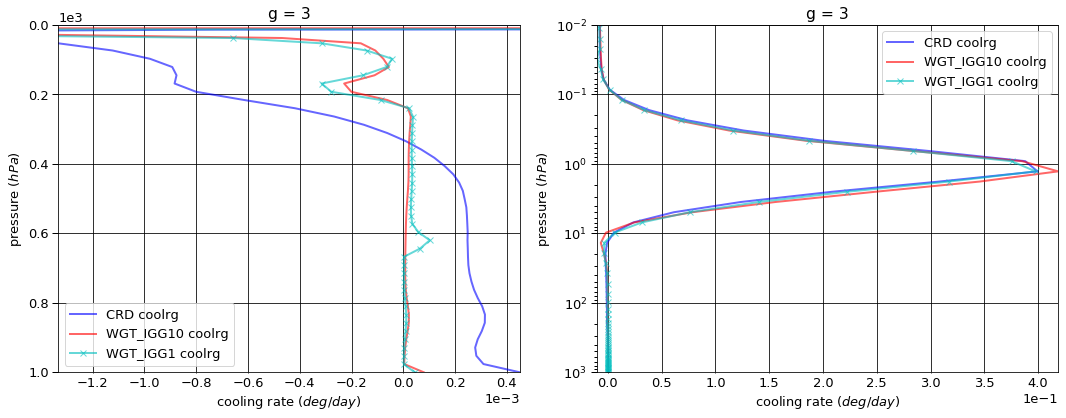

# Figure: cooling rate g-group 4

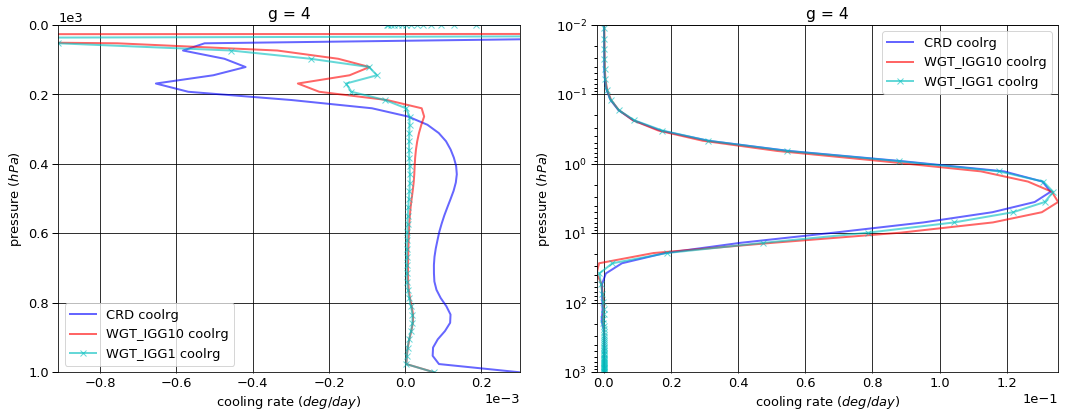

# Figure: cooling rate g-group 5

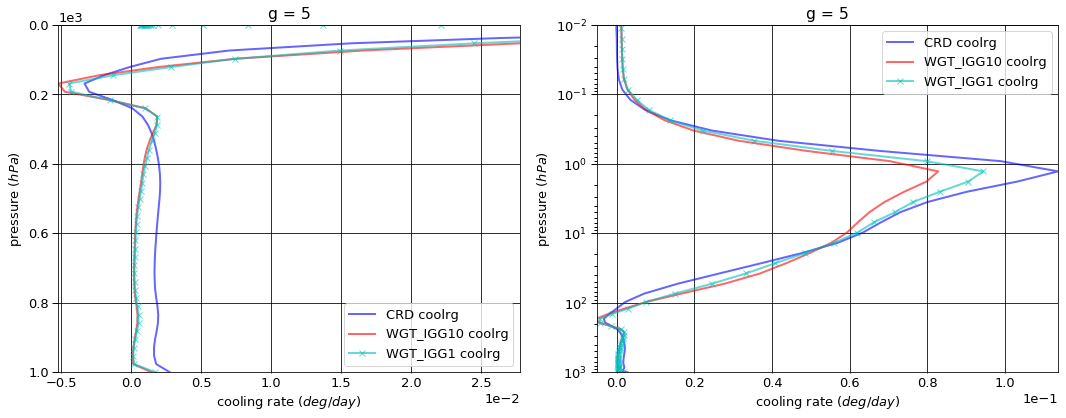

# Figure: cooling rate g-group 6

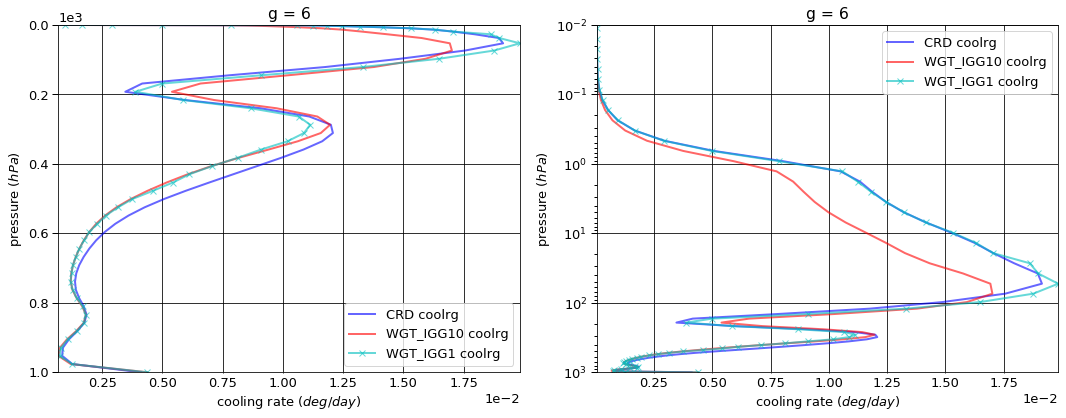

# Figure: cooling rate g-group 7

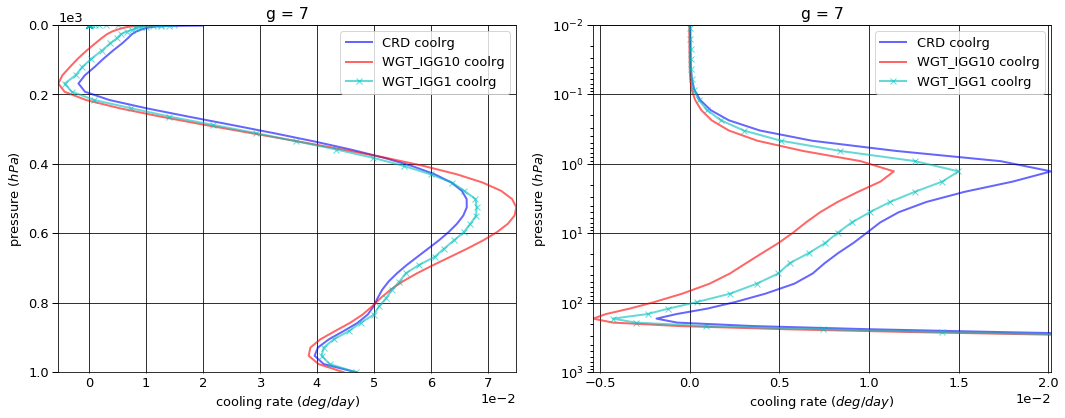

# Figure: cooling rate g-group 8

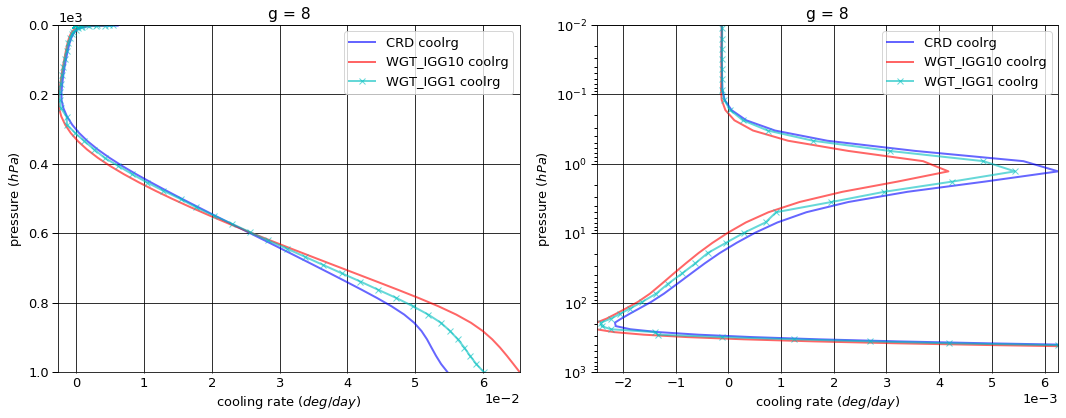

# Figure: cooling rate g-group 9

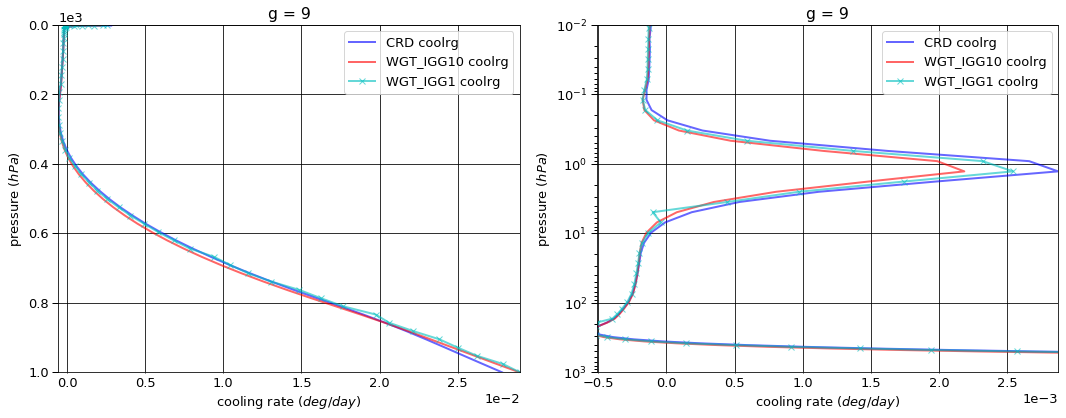

# Figure: cooling rate g-group total

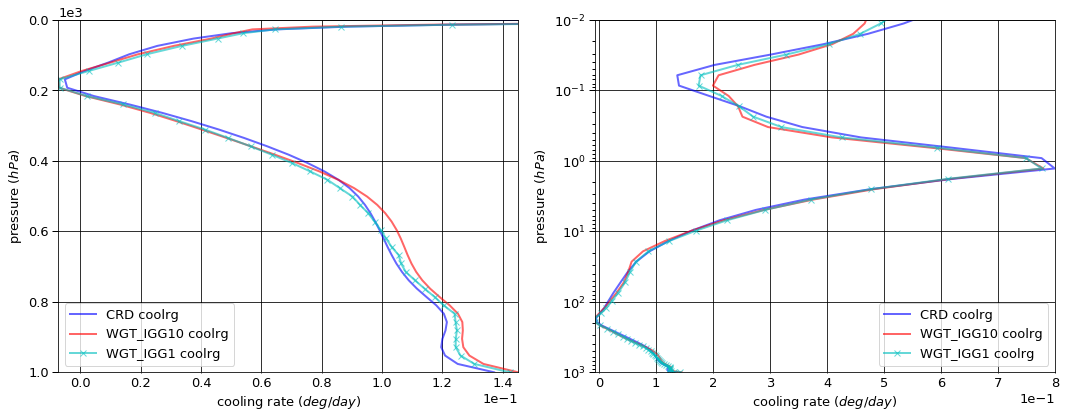

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009852  0.000000  -0.009852
  1013.0   76     -0.028660  0.028622  -0.000038
2 0.0      1      -0.022518  0.000000  -0.022518
  1013.0   76     -0.036030  0.035895  -0.000135
3 0.0      1      -0.126953  0.000000  -0.126953
  1013.0   76     -0.215283  0.208642  -0.006640
4 0.0      1      -0.170384  0.000000  -0.170384
  1013.0   76     -0.375365  0.373799  -0.001566
5 0.0      1      -0.489733  0.000000  -0.489733
  1013.0   76     -1.284539  1.232336  -0.052203
6 0.0      1      -0.758490  0.000000  -0.758490
  1013.0   76     -2.300377  2.285287  -0.015090
7 0.0      1      -5.273383  0.000000  -5.273383
  1013.0   76     -9.669023  9.090160  -0.578863
8 0.0      1      -5.889087  0.000000  -5.889087
  1013.0   76     -6.947446  3.555735  -3.391711
9 0.0      1     -11.530339  0.000000 -11.530339
  1013.0   76    -11.780821  1.143638 -10.637183


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.008997  0.000000  -0.008997
  1013.0   76     -0.028660  0.028644  -0.000016
2 0.0      1      -0.023158  0.000000  -0.023158
  1013.0   76     -0.036030  0.035997  -0.000033
3 0.0      1      -0.131740  0.000000  -0.131740
  1013.0   76     -0.215283  0.215064  -0.000219
4 0.0      1      -0.175144  0.000000  -0.175144
  1013.0   76     -0.375365  0.375154  -0.000211
5 0.0      1      -0.408763  0.000000  -0.408763
  1013.0   76     -1.284539  1.280284  -0.004255
6 0.0      1      -0.713850  0.000000  -0.713850
  1013.0   76     -2.300377  2.285417  -0.014960
7 0.0      1      -5.203904  0.000000  -5.203904
  1013.0   76     -9.669023  9.218350  -0.450673
8 0.0      1      -5.882429  0.000000  -5.882429
  1013.0   76     -6.947446  3.811211  -3.136235
9 0.0      1     -11.543758  0.000000 -11.543758
  1013.0   76    -11.780821  1.115336 -10.665485


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009192  0.000000  -0.009192
  1013.0   76     -0.028660  0.028644  -0.000016
2 0.0      1      -0.022823  0.000000  -0.022823
  1013.0   76     -0.036030  0.036009  -0.000020
3 0.0      1      -0.128914  0.000000  -0.128914
  1013.0   76     -0.215283  0.215161  -0.000121
4 0.0      1      -0.173042  0.000000  -0.173042
  1013.0   76     -0.375365  0.375156  -0.000209
5 0.0      1      -0.411857  0.000000  -0.411857
  1013.0   76     -1.284539  1.279403  -0.005136
6 0.0      1      -0.720043  0.000000  -0.720043
  1013.0   76     -2.300377  2.284992  -0.015385
7 0.0      1      -5.212428  0.000000  -5.212428
  1013.0   76     -9.669023  9.133795  -0.535228
8 0.0      1      -5.862155  0.000000  -5.862155
  1013.0   76     -6.947446  3.708679  -3.238766
9 0.0      1     -11.528360  0.000000 -11.528360
  1013.0   76    -11.780821  1.160649 -10.620172


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      8.549299e-04  0.000000  0.000855
  1013.0   76    -3.469447e-18  0.000022  0.000022
2 0.0      1     -6.398330e-04  0.000000 -0.000640
  1013.0   76     0.000000e+00  0.000102  0.000102
3 0.0      1     -4.787060e-03  0.000000 -0.004787
  1013.0   76     0.000000e+00  0.006421  0.006421
4 0.0      1     -4.759810e-03  0.000000 -0.004760
  1013.0   76     0.000000e+00  0.001355  0.001355
5 0.0      1      8.097050e-02  0.000000  0.080971
  1013.0   76     0.000000e+00  0.047948  0.047948
6 0.0      1      4.463960e-02  0.000000  0.044640
  1013.0   76     4.440892e-16  0.000130  0.000130
7 0.0      1      6.947910e-02  0.000000  0.069479
  1013.0   76     0.000000e+00  0.128190  0.128190
8 0.0      1      6.658600e-03  0.000000  0.006659
  1013.0   76    -8.881784e-16  0.255476  0.255476
9 0.0      1     -1.341900e-02  0.000000 -0.013419
  1013.0   76     1.776357e-15 -0.028302 -0.028302


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      6.607232e-04  0.000000  0.000661
  1013.0   76    -3.469447e-18  0.000022  0.000022
2 0.0      1     -3.048150e-04  0.000000 -0.000305
  1013.0   76     0.000000e+00  0.000115  0.000115
3 0.0      1     -1.961450e-03  0.000000 -0.001961
  1013.0   76     0.000000e+00  0.006519  0.006519
4 0.0      1     -2.657920e-03  0.000000 -0.002658
  1013.0   76     0.000000e+00  0.001357  0.001357
5 0.0      1      7.787671e-02  0.000000  0.077877
  1013.0   76     0.000000e+00  0.047067  0.047067
6 0.0      1      3.844713e-02  0.000000  0.038447
  1013.0   76     4.440892e-16 -0.000295 -0.000295
7 0.0      1      6.095510e-02  0.000000  0.060955
  1013.0   76     0.000000e+00  0.043635  0.043635
8 0.0      1      2.693200e-02  0.000000  0.026932
  1013.0   76    -8.881784e-16  0.152944  0.152944
9 0.0      1      1.979000e-03  0.000000  0.001979
  1013.0   76     1.776357e-15  0.017012  0.017011

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.652334
  1001.112500 75     0.000013
2 0.000312    1     -0.001948
  1001.112500 75     0.000036
3 0.000312    1     -0.010292
  1001.112500 75     0.000450
4 0.000312    1     -0.000062
  1001.112500 75     0.000301
5 0.000312    1     -0.000513
  1001.112500 75     0.002764
6 0.000312    1      0.000020
  1001.112500 75     0.004112
7 0.000312    1     -0.000031
  1001.112500 75     0.046873
8 0.000312    1     -0.000114
  1001.112500 75     0.054783
9 0.000312    1     -0.000109
  1001.112500 75     0.027831


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.409174
  1001.112500 75     0.000006
2 0.000312    1     -0.016146
  1001.112500 75     0.000012
3 0.000312    1     -0.009593
  1001.112500 75     0.000079
4 0.000312    1      0.000004
  1001.112500 75     0.000076
5 0.000312    1      0.000712
  1001.112500 75     0.001473
6 0.000312    1      0.000020
  1001.112500 75     0.004379
7 0.000312    1     -0.000055
  1001.112500 75     0.044727
8 0.000312    1     -0.000115
  1001.112500 75     0.065425
9 0.000312    1     -0.000106
  1001.112500 75     0.028946


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.510942
  1001.112500 75     0.000006
2 0.000312    1     -0.017162
  1001.112500 75     0.000007
3 0.000312    1     -0.010499
  1001.112500 75     0.000044
4 0.000312    1     -0.000048
  1001.112500 75     0.000075
5 0.000312    1      0.000644
  1001.112500 75     0.001713
6 0.000312    1      0.000027
  1001.112500 75     0.004376
7 0.000312    1     -0.000018
  1001.112500 75     0.046957
8 0.000312    1     -0.000110
  1001.112500 75     0.060146
9 0.000312    1     -0.000111
  1001.112500 75     0.028970


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.431592e-01
  1001.112500 75    -7.062806e-06
2 0.000312    1     -1.419745e-02
  1001.112500 75    -2.409904e-05
3 0.000312    1      6.990105e-04
  1001.112500 75    -3.709227e-04
4 0.000312    1      6.581462e-05
  1001.112500 75    -2.245930e-04
5 0.000312    1      1.224895e-03
  1001.112500 75    -1.290626e-03
6 0.000312    1      3.492530e-07
  1001.112500 75     2.668452e-04
7 0.000312    1     -2.453373e-05
  1001.112500 75    -2.146680e-03
8 0.000312    1     -9.145400e-07
  1001.112500 75     1.064166e-02
9 0.000312    1      3.339640e-06
  1001.112500 75     1.114730e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.141391
  1001.112500 75    -0.000007
2 0.000312    1     -0.015214
  1001.112500 75    -0.000029
3 0.000312    1     -0.000208
  1001.112500 75    -0.000406
4 0.000312    1      0.000014
  1001.112500 75    -0.000225
5 0.000312    1      0.001158
  1001.112500 75    -0.001051
6 0.000312    1      0.000007
  1001.112500 75     0.000264
7 0.000312    1      0.000013
  1001.112500 75     0.000084
8 0.000312    1      0.000004
  1001.112500 75     0.005362
9 0.000312    1     -0.000002
  1001.112500 75     0.001139

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-24.270740,0.000000,-24.270740
1013.0,76,-32.637543,17.954113,-14.683429



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-24.091743,0.000000,-24.091743
1013.0,76,-32.637543,18.365457,-14.272086



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-24.068813,0.000000,-24.068813
1013.0,76,-32.637543,18.222489,-14.415054



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.789970e-01,0.000000,0.178997
1013.0,76,7.105427e-15,0.411343,0.411343



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.019265e-01,0.000000,0.201926
1013.0,76,7.105427e-15,0.268376,0.268375


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.639284
1001.112500,75,0.137163



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.383896
1001.112500,75,0.145123



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.483665
1001.112500,75,0.142294



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.255389
1001.112500,75,0.007959



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.155619
1001.112500,75,0.005131


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000850,0.000901
2,0.001075,0.001127
3,0.006450,0.006712
4,0.011150,0.011783
5,0.038525,0.040010
6,0.068675,0.071889
7,0.290038,0.301040
8,0.213775,0.212014
9,0.369463,0.354524


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.310867e-19
2,2.133976e-20
3,1.970626e-21
4,1.774707e-21
5,1.647913e-22
6,5.838237e-22
7,6.101170e-23
8,6.375943e-24
9,2.959058e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.310867e-19,NaN,0.000850,0.000901,0.000850,0.000901,1.0
2,2.133976e-20,0.092345,0.001075,0.001127,0.001925,0.002028,1.0
3,1.970626e-21,0.092345,0.006450,0.006712,0.008375,0.008740,1.0
4,1.774707e-21,0.900580,0.011150,0.011783,0.019525,0.020522,10.0
5,1.647913e-22,0.092856,0.038525,0.040010,0.058050,0.060533,10.0
6,5.838237e-22,3.542806,0.068675,0.071889,0.126725,0.132421,500.0
7,6.101170e-23,0.104504,0.290038,0.301040,0.416763,0.433461,500.0
8,6.375943e-24,0.104504,0.213775,0.212014,0.630537,0.645476,500.0
9,2.959058e-25,0.046410,0.369463,0.354524,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
